In [0]:
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json 

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, TimeDistributed
from keras.optimizers import SGD, Adam, rmsprop
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [0]:
APIKEY = "YZ9B8Z2SIH1P1YEQ"
PATH = "https://www.alphavantage.co/query?"
SYMBOL = "BHP.AX"
MODE = ["TIME_SERIES_INTRADAY", "TIME_SERIES_DAILY", "TIME_SERIES_WEEKLY", "TIME_SERIES_MONTHLY"]


def get_data_csv(function, symbol):
  datetime.today
  save_path = f"{function}_{symbol.replace('.', '_')}.csv"
  
  params = {
      "function": function,
      "symbol": symbol,
      "apikey": APIKEY,
      "datatype": "csv",
  }

  if function == "TIME_SERIES_INTRADAY":
    params["interval"] = "5min"

  response = requests.get(PATH, params=params)
  print(f"{function} status code: {response.status_code}")
  if response.status_code == 200:
    with open(save_path, "wb") as handler:
      handler.write(response.content)

  return save_path

In [0]:
file_paths = []
for mode in MODE:
  file_paths.append(get_data_csv(mode, SYMBOL))

TIME_SERIES_INTRADAY status code: 200
TIME_SERIES_DAILY status code: 200
TIME_SERIES_WEEKLY status code: 200
TIME_SERIES_MONTHLY status code: 200


In [0]:
file_paths = ['TIME_SERIES_INTRADAY_BHP_AX.csv', 'TIME_SERIES_DAILY_BHP_AX.csv', 'TIME_SERIES_WEEKLY_BHP_AX.csv', 'TIME_SERIES_MONTHLY_BHP_AX.csv']

In [0]:
intraday = pd.read_csv(file_paths[0], index_col=0).iloc[::-1]
daily = pd.read_csv(file_paths[1], index_col=0).iloc[::-1]
weekly = pd.read_csv(file_paths[2], index_col=0).iloc[::-1]
monthly = pd.read_csv(file_paths[3], index_col=0).iloc[::-1]

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


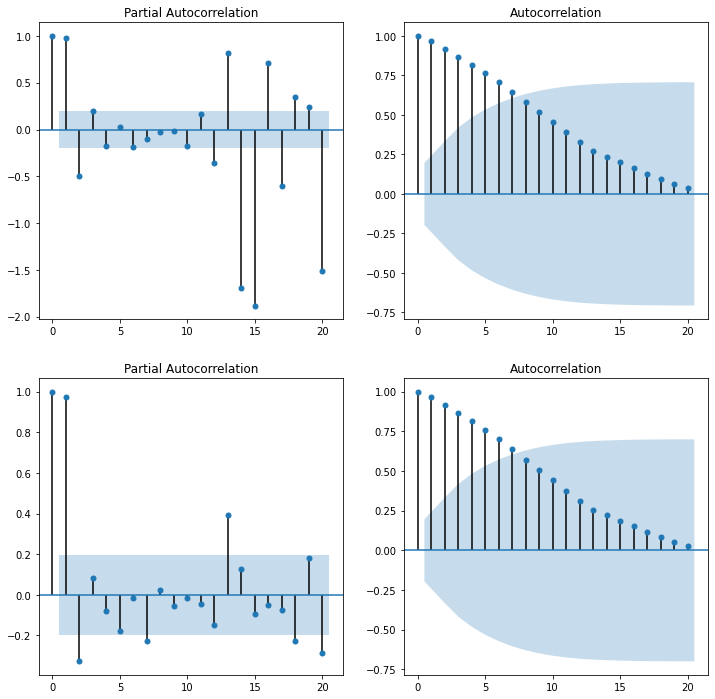

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plot_pacf(daily["high"].values, ax=axes[0][0])
plot_acf(daily["high"].values, ax=axes[0][1])
plot_pacf(daily["low"].values, ax=axes[1][0])
plot_acf(daily["low"].values, ax=axes[1][1])
plt.show()

In [0]:
DF = daily
IN, OUT, VAR = 2, 1, 2

In [0]:
DF.head()

,open,high,low,close,volume
timestamp,,,,,
2019-11-01,35.40,35.74,35.400,35.70,6753664
2019-11-04,36.37,36.54,36.280,36.48,6183219
2019-11-05,36.98,37.05,36.860,36.95,5898441
2019-11-06,37.58,37.61,37.390,37.50,7138070
2019-11-07,37.31,37.35,37.065,37.35,5847439


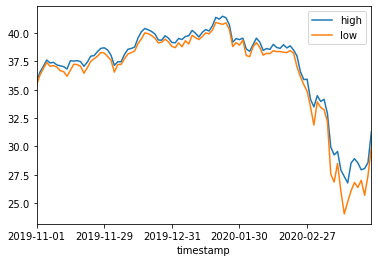

In [0]:
DF.iloc[:, 1:3].plot()

In [0]:
def transform_data(df, n_in, n_out):
  tdf = df[["low", "high"]]
  cols, names = [], []

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(tdf.shift(i))
    names += [f"{name} (t-{i})" for name in tdf.columns]

	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(tdf.shift(-i))
    if i == 0:
      names += [f"{name} (t)" for name in tdf.columns]
    else:
      names += [f"{name} (t+{i})" for name in tdf.columns]
  
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  agg.dropna(inplace=True)
  return agg

In [0]:
tdf = transform_data(DF, IN, OUT)
tdf.tail() 

,low (t-7,high (t-7,low (t-6,high (t-6,low (t-5,high (t-5,low (t-4,high (t-4,low (t-3,high (t-3,low (t-2,high (t-2,low (t-1,high (t-1,low (t),high (t)
timestamp,,,,,,,,,,,,,,,,
2020-03-19,26.86,29.25,28.50,29.55,26.01,27.90,24.05,27.34,25.11,26.78,26.09,28.54,26.82,28.920,26.38,28.550
2020-03-20,28.50,29.55,26.01,27.90,24.05,27.34,25.11,26.78,26.09,28.54,26.82,28.92,26.38,28.550,27.01,27.940
2020-03-23,26.01,27.90,24.05,27.34,25.11,26.78,26.09,28.54,26.82,28.92,26.38,28.55,27.01,27.940,25.69,28.050
2020-03-24,24.05,27.34,25.11,26.78,26.09,28.54,26.82,28.92,26.38,28.55,27.01,27.94,25.69,28.050,27.42,28.565
2020-03-25,25.11,26.78,26.09,28.54,26.82,28.92,26.38,28.55,27.01,27.94,25.69,28.05,27.42,28.565,29.92,31.300


In [0]:
x = tdf.iloc[:, :IN * VAR].values
x_scaler = StandardScaler()
x_scaler.fit(x)
x = x_scaler.transform(x).reshape((-1, IN, VAR))

y = tdf.iloc[:, IN * VAR:].values
y_scaler = StandardScaler()
y_scaler.fit(y)
y = y_scaler.transform(y)

VALSIZE = 10
x_train, y_train = x[:-VALSIZE], y[:-VALSIZE]
x_val, y_val = x[-VALSIZE:], y[-VALSIZE:]

In [0]:
def build_model(n_layer, n_hidden, n_in, n_out, n_var, stf=False, layer_type="lstm"):
  model = Sequential()
  
  LAYER = LSTM if layer_type.lower() == "lstm" else GRU
  if n_layer == 1:
    model.add(LAYER(n_hidden, stateful=stf, input_shape=(n_in, n_var)))
  else:
    model.add(LAYER(n_hidden, return_sequences=True, stateful=stf, input_shape=(n_in, n_var)))
    for _ in range(n_layer - 2):
      model.add(LAYER(n_hidden, return_sequences=True, stateful=stf))
    model.add(LAYER(n_hidden, stateful=stf))
  model.add(Dense(n_out * n_var))
  model.compile(optimizer=Adam(lr=1e-6), loss="mse", metrics=["mse", "mae"])
  return model

In [0]:
def evaluate(model, x_train, y_train, x_val=None, y_val=None):
  y_hat = model.predict(x_train, batch_size=1, verbose=0)
  print(f"train mse: {mean_squared_error(y_train, y_hat):.2f}")
  print(f"train mae: {mean_absolute_error(y_train, y_hat):.2f}")
  if not(x_val is None or y_val is None):
    y_hat = model.predict(x_val, batch_size=1, verbose=0)
    print(f"val mse: {mean_squared_error(y_val, y_hat):.2f}")
    print(f"val mae: {mean_absolute_error(y_val, y_hat):.2f}")

In [0]:
def extrapolate(model, df, n_in, n_out, n_var):
  x = df[["low", "high"]].iloc[-n_in:].values.reshape(1, -1)
  x = x_scaler.transform(x).reshape((1, n_in, n_var))
  y_hat = model.predict(x, batch_size=1, verbose=0)
  y_hat = y_scaler.inverse_transform(y_hat).reshape(n_out, n_var)
  index = pd.to_datetime(list(range(1, n_out + 1)), unit='D', origin=df.index[-1])
  return pd.DataFrame(y_hat, index=index, columns=["low", "high"])

In [0]:
model_path = "training/weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(model_path, monitor="val_loss", verbose=0, save_best_only=True)
csv_logger = CSVLogger('training/training.log')
EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [0]:
# build model
model = build_model(2, 128, IN, OUT, VAR, layer_type="gru")
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_37 (GRU)                 (None, 7, 128)            50304     
_________________________________________________________________
gru_38 (GRU)                 (None, 128)               98688     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 258       
Total params: 149,250
Trainable params: 149,250
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train model
history = model.fit(x_train, y_train, epochs=200, batch_size=10, callbacks=[csv_logger, reduce_lr], 
          validation_data=(x_val, y_val), shuffle=False)

Train on 83 samples, validate on 10 samples
Epoch 1/200
83/83 [==============================] - 0s 3ms/step - loss: 0.0999 - mean_squared_error: 0.0999 - mean_absolute_error: 0.2284 - val_loss: 0.4432 - val_mean_squared_error: 0.4432 - val_mean_absolute_error: 0.5394
Epoch 2/200
83/83 [==============================] - 0s 3ms/step - loss: 0.0998 - mean_squared_error: 0.0998 - mean_absolute_error: 0.2281 - val_loss: 0.4413 - val_mean_squared_error: 0.4413 - val_mean_absolute_error: 0.5379
Epoch 3/200
83/83 [==============================] - 0s 3ms/step - loss: 0.0996 - mean_squared_error: 0.0996 - mean_absolute_error: 0.2279 - val_loss: 0.4394 - val_mean_squared_error: 0.4394 - val_mean_absolute_error: 0.5364
Epoch 4/200
83/83 [==============================] - 0s 3ms/step - loss: 0.0994 - mean_squared_error: 0.0994 - mean_absolute_error: 0.2276 - val_loss: 0.4375 - val_mean_squared_error: 0.4375 - val_mean_absolute_error: 0.5348
Epoch 5/200
83/83 [==============================] - 0s 

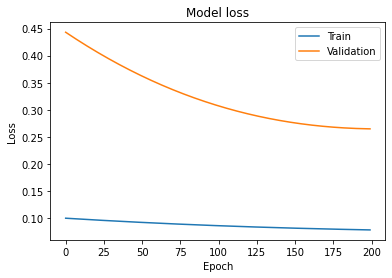

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [0]:
# evaluate model
evaluate(model, x_train, y_train, x_val, y_val)

train mse: 0.08
train mae: 0.20
val mse: 0.26
val mae: 0.41


In [0]:
# predict future
predictions = extrapolate(model, DF, IN, OUT, VAR)
predictions

,low,high
2020-03-26,26.867008,28.109259
